In [57]:
import numpy as np
from threeflavorALLvalues import allSigmas
from scipy.integrate import odeint
from solveTmu import blackness
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from scipy.optimize import brentq, fsolve

from joblib import Parallel, delayed

import matplotlib.pyplot as plt

import pandas as pd


In [2]:
"Matching Fang paper"
v4=4.2
v3= -22.6/(6*np.sqrt(2))

def chiral(u,y,params):
    chi,chip=y
    v3,v4,lambda1,mu_g,a0,zh,q=params
    
    Q=q*zh**3
    
    
    "Ballon-Bayona version"
    phi = (mu_g*zh*u)**2-a0*(mu_g*zh*u)**3/(1+(mu_g*zh*u)**4)
    phip = 2*u*(zh*mu_g)**2+a0*(4*u**6*(zh*mu_g)**7/(1+(u*zh*mu_g)**4)**2-3*u**2*(zh*mu_g)**3/(1+(u*zh*mu_g)**4))

    f= 1 - (1+Q**2)*u**4 + Q**2*u**6
    fp= -4*(1+Q**2)*u**3 + 6*Q**2*u**5
    "EOM for chiral field"
    derivs=[chip,
            (3/u-fp/f+phip)*chip - (3*chi+lambda1*phi*chi-3*v3*chi**2-4*v4*chi**3)/(u**2*f)]
            #((3+u**4)/(u-u**5) +phip)*chip - (-3*chi+4*v4*chi**3)/(u**2-u**6) ]
            
    return derivs

def chiral_solve_IR(d0,lambda1,T,mu,ui,uf):
    numpoints=10000
    u=np.linspace(ui,uf,numpoints)
    u_backward=np.linspace(uf,ui,numpoints)


    zeta=np.sqrt(3)/(2*np.pi)

    mu_g=440
    a0=0

    lambda3=v3
    lambda4=v4


    zh,q = blackness(T,mu)
    Q=q*zh**3
    
    #defining constants for Taylor expansion at horizon u=1

    d1 = (3 * d0 - 3 * d0**2 * lambda3 - 4 * d0**3 * lambda4 + d0 * zh**2 * lambda1 * mu_g**2) / (2 * (-2 + Q**2))

    d2 = (1 / (16 * (-2 + Q**2)**2)) * (6 * d1 * (-6 + Q**2 + Q**4) +
    4 * d0**3 * (14 - 13 * Q**2) * lambda4 + d0**2 * ((42 - 39 * Q**2) * lambda3 - 24 * d1 * (-2 + Q**2) * lambda4) -
    2 * d1 * (-2 + Q**2) * zh**2 * (-8 + 4 * Q**2 - lambda1) * mu_g**2 +
    3 * d0 * (-14 + 13 * Q**2 + 8 * d1 * lambda3 - 4 * d1 * Q**2 * lambda3 + (-2 + 3 * Q**2) * zh**2 * lambda1 * mu_g**2))
    

    "IR boundary condition"
    chi0 = d0+d1*(1-uf)+d2*(1-uf)**2
    chip0 = -d1-2*d2*(1-uf)
    y0=[chi0,chip0]




    params=v3,v4,lambda1,mu_g,a0,zh,q
    
    "solve the EOM using solve_ivp"
    sol = solve_ivp(chiral, [uf, ui], y0, t_eval=u_backward, args=(params,))

    #sol=odeint(chiral,y0,u,args=(params,))
    #plot
    chi=sol.y[0][::-1]
    chip=sol.y[1][::-1]
 
    x=zeta*zh*ui
    #first-order approximation
    if v3==0:
        mq1=chi[0]/(zeta*zh*ui)
    else:
        #second-order approximation
       mq1=(x-x*np.sqrt(1-12*v3*chi[0]))/(6*x**2*v3)


    return mq1,chi,chip,u

def sigma_finder(u_intermediate,chi,u,mq,T,mu,zeta,lambda3):
    zh,q = blackness(T,mu)

    "find sigma"
    chi_interp=interp1d(u,chi)
    sigma=(chi_interp(u_intermediate)-mq*zeta*zh*u_intermediate+3*mq**2*zeta**2*lambda3*(zh*u_intermediate)**2)/(u_intermediate*zh)**3*zeta
    return sigma


def chiral_solve_IR_parallel(d0_array, lambda1, T, mu, ui, uf, n_jobs=-1):
    results = Parallel(n_jobs=n_jobs)(
        delayed(chiral_solve_IR)(d0, lambda1, T, mu, ui, uf) for d0 in d0_array
    )
    # Unpack the results
    mq_array, chi_array, chip_array, u_array = zip(*results)
    
    return np.array(mq_array), np.array(chi_array), np.array(chip_array)

In [3]:
#run this to get the initial range of mq vs d0
#mq target should be 50 MeV or some large number
def initial_d0_mq(T,mu,mq_target,lambda1,ui,uf,d0_array):
    
#     d0_array=np.linspace(d0_lower,d0_upper,100)
    mq_array=chiral_solve_IR_parallel(d0_array, lambda1, T, mu, ui, uf, n_jobs=-1)[0]

    max_d0=d0_array[-1]
    # find the indices where abs(mq_array)>150, and remove those indices from d0_array and mq_array
    indices=np.where(np.abs(mq_array)>150)
    # we don't need to go higher than the lowest d0 value that gives garbage results
    # if indices is not an empty array
    if len(indices[0])>0:
        max_d0=d0_array[indices[0]]
    if len(indices[0])>1:
        max_d0=max_d0[0]

    d0_array=np.delete(d0_array,indices)
    mq_array=np.delete(mq_array,indices)
#     mq1_array=np.delete(mq1_array,indices)
    
    iterations=0
    step_size=d0_array[1]-d0_array[0]
    while mq_array[-1]<mq_target and iterations<20:
    #while max(mq_array)<mq_target and iterations<12:

        #create a new d0_array starting above the maximum value of d0_array, with a spacing that is 1/10 of the spacing of the previous d0_array
        step_size=step_size/100
        d0_new=np.arange(max(d0_array),min(max(d0_array)+(d0_array[-1]-d0_array[0])/20,max_d0),step_size)

        # d0_new=np.arange(max(d0_array),min(max(d0_array)+(d0_array[-1]-d0_array[0])/10,max_d0),((d0_array[1]-d0_array[0])/100))
        # d0_new=np.arange(max(d0_array),min(max(d0_array)+(d0_array[-1]-d0_array[0])/10,max_d0),step_size)
        d0_array=np.concatenate((d0_array,d0_new))
        #calculate the mq_array for the new d0_array
        mq_new=chiral_solve_IR_parallel(d0_new, lambda1, T, mu, ui, uf, n_jobs=-1)[0]
        #add the new mq_array to the old mq_array
        mq_array=np.concatenate((mq_array,mq_new))
#         mq1_array=np.concatenate((mq1_array,mq1_new))

        
        indices=np.where(np.abs(mq_array)>150)
        # we don't need to go higher than the lowest d0 value that gives garbage results
        # if indices is not an empty array
        if len(indices[0])>0:
            max_d0=d0_array[indices[0]]
        if len(indices[0])>1:
            max_d0=max_d0[0]    
        d0_array=np.delete(d0_array,indices)
        mq_array=np.delete(mq_array,indices)
#         mq1_array=np.delete(mq1_array,indices)

        # print(max_d0)
        old_max_d0=max_d0
        iterations=iterations+1
    # print('iterations',iterations)
    if mq_array[-1]-mq_array[-2]>5:
        #create an array of 10 new d0 values evenly spaced between the last two d0 values, that doesn't include either of the last two d0 values
        d0_new=np.linspace(d0_array[-2],d0_array[-1],10)[1:-1]
        #calculate the mq_array for the new d0_array
        mq_new=chiral_solve_IR_parallel(d0_new, lambda1, T, mu, ui, uf, n_jobs=-1)[0]
        #add the new mq_array to the old mq_array between the last two mq values, same for d0
        mq_array=np.concatenate((mq_array[:-1],mq_new,mq_array[-1:]))
        d0_array=np.concatenate((d0_array[:-1],d0_new,d0_array[-1:]))
    return d0_array,mq_array

# finding a range of d0 values that will cover quark masses in a range from 0 to approximately mq_large
# T=1
# mu=0
# mq_large=15
# lambda1=5.7
# ui=1e-4
# uf=1-ui
# numpoints=100
# d0_lower=70
# d0_upper=88
# d0_array=np.linspace(d0_lower,d0_upper,numpoints)
# d0_array, mq_array = initial_d0_mq(T, mu, mq_large, lambda1, ui, uf, d0_array)

# d0_old=d0_array
# d0_min=d0_array[np.abs(mq_array)>1e-3][0]
# mq_array=mq_array[d0_array>d0_min]
# d0_array=d0_array[d0_array>d0_min]
# # it seems that the first two points are identical, so remove one
# d0_array=d0_array[1:]
# mq_array=mq_array[1:]
# "This works, but makes WAY too many points"
# # smallest_diff=np.min(np.gradient(d0_array))

# # d0_array=np.arange(d0_array[0],d0_array[-1]+smallest_diff,smallest_diff)

# # d0_array, mq_array = initial_d0_mq(T, mu, mq_large, lambda1, ui, uf, d0_array)

# # solving from IR again to retain the function chi and its derivative chip for each value of d0
# _,chis,chips=chiral_solve_IR_parallel(d0_array, lambda1, T, mu, ui, uf, n_jobs=-1)

# #picking the value of u_int. There are 1000 points in u, so i ~ 1000*u_int
# i=10
# u=np.linspace(ui,uf,len(chips[0]))
# u_int=u[i]
# chi0=chis[:,i]
# chip0=chips[:,i]

# #solving for mq and sigma
# lambda3=v3
# zeta=np.sqrt(3)/(2*np.pi)
# zh,q=blackness(T,mu)
# # if lambda3 is nonzero, calculate mq and sigma using the improved formula
# # if lambda3 is zero, calculate mq and sigma using the round formula
# if lambda3==0:
#     sigma_improved=zeta*(chip0*u_int-chi0)/(2*u_int**3*zh**3)
#     mq_improved=mq_array#chi0/(zeta*zh*u_int)
# else:
#     mq_improved=(1-np.sqrt(1-3*lambda3*(3*chi0-chip0*u_int)))/(3*lambda3*zeta*u_int*zh)
#     sigma_improved=zeta*(1-6*chi0*lambda3+3*chip0*u_int*lambda3-np.sqrt(1-3*lambda3*(3*chi0-chip0*u_int)))/(3*u_int**3*zh**3*lambda3)



In [4]:
# The function that will run in parallel
def process_mq_target(mq_target, d0_array, mq_improved, sigma_improved, lambda1, T, mu, ui, uf, v3):
    # Your additional function calls like chiral_solve_IR, blackness go here
    
    d0_list = d0_array.tolist()
    mq_list = mq_improved.tolist()
    sigma_list = sigma_improved.tolist()
    
    indices = np.where(np.diff(np.sign(mq_improved - mq_target)))[0]
    
    results = []
    for index in indices:
        mq_approx = np.array([mq_improved[index], mq_improved[index + 1]])
        d0_approx = np.array([d0_array[index], d0_array[index + 1]])
        
        d0_interp = interp1d(mq_approx, d0_approx)
        d0 = d0_interp(mq_target)
        mq,chi,chip,u=chiral_solve_IR(d0,lambda1,T,mu,ui,uf)
#         print(mq)
        #picking the value of u_int. There are 1000 points in u, so i ~ 1000*u_int
        i=10
        u=np.linspace(ui,uf,len(chip))
        u_int=u[i]
        chi0=chi[i]
        chip0=chip[i]

        #solving for mq and sigma
        lambda3=v3
        zeta=np.sqrt(3)/(2*np.pi)
        zh,q=blackness(T,mu)
        # if lambda3 is nonzero, calculate mq and sigma using the improved formula
        # if lambda3 is zero, calculate mq and sigma using the round formula
        if lambda3==0:
            sigma_new=zeta*(chip0*u_int-chi0)/(2*u_int**3*zh**3)
            mq_new=mq#chi0/(zeta*zh*u_int)
        else:
            mq_new=(1-np.sqrt(1-3*lambda3*(3*chi0-chip0*u_int)))/(3*lambda3*zeta*u_int*zh)
            sigma_new=zeta*(1-6*chi0*lambda3+3*chip0*u_int*lambda3-np.sqrt(1-3*lambda3*(3*chi0-chip0*u_int)))/(3*u_int**3*zh**3*lambda3)
            sigma_approx = zeta/(3*u_int**3*zh**3*lambda3)*(2*chip0*u_int-3/2*chi0)
            # sigma_improved=sigma_approx
#         print("d0=",d0)
        
        d0_list.append(d0)
        mq_list.append(mq_new)
        sigma_list.append(sigma_new)
        
    return np.array(d0_list), np.array(mq_list), np.array(sigma_list)

# # Main code
# numMass = 100
# mq_overlay = np.linspace(np.min(mq_improved), mq_large, numMass)

# results = Parallel(n_jobs=-1)(delayed(process_mq_target)(mq_target, d0_array, mq_improved, sigma_improved, lambda1, T, mu, ui, uf, v3) for mq_target in mq_overlay)

# # Aggregate results
# all_d0_arrays = [res[0] for res in results]
# all_mq_improved = [res[1] for res in results]
# all_sigma_improved = [res[2] for res in results]

# # Concatenating all the arrays
# all_d0_array = np.concatenate(all_d0_arrays)
# all_mq_improved = np.concatenate(all_mq_improved)
# all_sigma_improved = np.concatenate(all_sigma_improved)

# # Sorting by d0_array
# sort_indices = np.argsort(all_d0_array)
# all_d0_array = all_d0_array[sort_indices]
# all_mq_improved = all_mq_improved[sort_indices]
# all_sigma_improved = all_sigma_improved[sort_indices]

# # Removing duplicate d0 values
# unique_indices = np.unique(all_d0_array, return_index=True)[1]
# final_d0_array = all_d0_array[unique_indices]
# mq_improved = all_mq_improved[unique_indices]
# sigma_improved = all_sigma_improved[unique_indices]




In [5]:

def new_function(lambda1, T, mu, mq_large, ui, uf, d0_lower, d0_upper, numpoints=100):
    # Initial d0 and mq arrays
    d0_array = np.linspace(d0_lower, d0_upper, numpoints)
    d0_array, mq_array = initial_d0_mq(T, mu, mq_large, lambda1, ui, uf, d0_array)

    # Further processing to get mq_improved and sigma_improved
    _, chis, chips = chiral_solve_IR_parallel(d0_array, lambda1, T, mu, ui, uf, n_jobs=-1)  # Assuming this function exists

    i = 10
    u = np.linspace(ui, uf, len(chips[0]))
    u_int = u[i]
    chi0 = chis[:, i]
    chip0 = chips[:, i]

    lambda3 = v3  
    zeta = np.sqrt(3) / (2 * np.pi)
    zh, q = blackness(T, mu)  
    
    if lambda3 == 0:
        sigma_improved = zeta * (chip0 * u_int - chi0) / (2 * u_int ** 3 * zh ** 3)
        mq_improved = mq_array
    else:
        mq_improved =(1 - np.sqrt(1 - 3 * lambda3 * (3 * chi0 - chip0 * u_int))) / (3 * lambda3 * zeta * u_int * zh)
        sigma_improved = zeta * (1 - 6 * chi0 * lambda3 + 3 * chip0 * u_int * lambda3 - np.sqrt(1 - 3 * lambda3 * (3 * chi0 - chip0 * u_int))) / (3 * u_int ** 3 * zh ** 3 * lambda3)
        sigma_approx = zeta/(3*u_int**3*zh**3*lambda3)*(2*chip0*u_int-3/2*chi0)
        # sigma_improved = sigma_approx

    # Run process_mq_target in parallel
    numMass = 100
    mq_overlay = np.linspace(np.min(mq_improved), mq_large, numMass)
    results = Parallel(n_jobs=-1)(delayed(process_mq_target)(mq_target, d0_array, mq_improved, sigma_improved, lambda1, T, mu, ui, uf, v3) for mq_target in mq_overlay)

    # Aggregate and sort results
    all_d0_arrays = [res[0] for res in results]
    all_mq_improved = [res[1] for res in results]
    all_sigma_improved = [res[2] for res in results]
    
    all_d0_array = np.concatenate(all_d0_arrays)
    all_mq_improved = np.concatenate(all_mq_improved)
    all_sigma_improved = np.concatenate(all_sigma_improved)

    sort_indices = np.argsort(all_d0_array)
    all_d0_array = all_d0_array[sort_indices]
    all_mq_improved = all_mq_improved[sort_indices]
    all_sigma_improved = all_sigma_improved[sort_indices]

    unique_indices = np.unique(all_d0_array, return_index=True)[1]
    final_d0_array = all_d0_array[unique_indices]
    mq_improved = all_mq_improved[unique_indices]
    sigma_improved = all_sigma_improved[unique_indices]

    return mq_improved, sigma_improved, final_d0_array

# Note: The function uses variables like v3, chiral_solve_IR_parallel, blackness which should already be defined in your context.




/var/folders/p2/x0t9bzsx00jdh9552ryvxndm0000gp/T/ipykernel_7210/1446935064.py:98: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(mq_array), np.array(chi_array), np.array(chip_array)


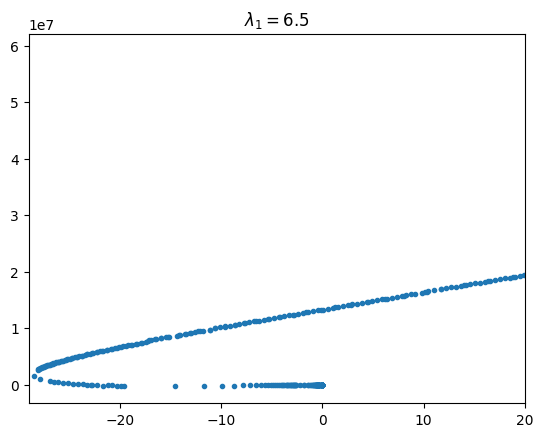

In [7]:
lambda1=6.5
T=5
mu=0
mq_large=20
ui=1e-4
uf=1-ui
d0_lower=0
d0_upper=40

mq_improved,sigma_improved, d0_array=new_function(lambda1,T,mu,mq_large,ui,uf,d0_lower,d0_upper,numpoints=100)

plt.plot(mq_improved,sigma_improved,'.')
plt.xlim([min(mq_improved)-.5,20])
#make the ylimits from 0 to the value of sigma improved at approximately mq=20 (there may not be a value of sigma_improved at exactly mq=20)
# plt.ylim([0,sigma_improved[np.where(mq_improved>20)[0][0]]/1e9])
# plt.ylim([0,np.max(sigma_improved)/1e9])
plt.title('$\lambda_1=$'+str(lambda1))
plt.show()

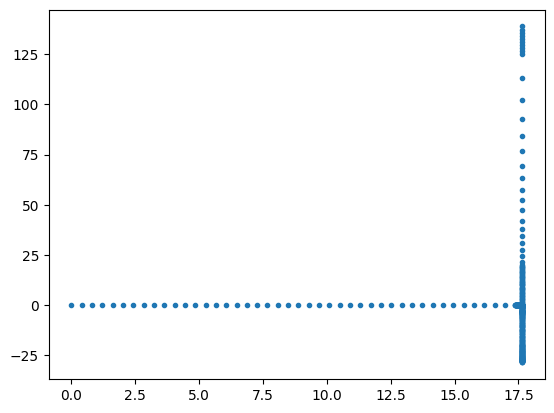

In [7]:
plt.plot(d0_array,mq_improved,'.')
plt.show()

In [8]:
# the quark mass I want to use
mq_input=9 
mq_tolerance=0.01
# find the indices where mq_improved-mq_input changes sign
indices=np.where(np.diff(np.sign(mq_improved-mq_input)))[0]
# for each element in indices
# if one of the surrounding values of mq_improved is within mq_tolerance of mq_input, then use that value of sigma_improved
# if not, interpolate between the two surrounding vlales of d0_array
sigma_list=[]
for index in indices:
    if np.abs(mq_improved[index]-mq_input)<mq_tolerance:
        sigma_input=sigma_improved[index]
    elif np.abs(mq_improved[index+1]-mq_input)<mq_tolerance:
        sigma_input=sigma_improved[index+1]
    else:
        sigma_interp=interp1d(mq_improved[index:index+2],sigma_improved[index:index+2])
        sigma_input=sigma_interp(mq_input)
    sigma_list.append(sigma_input)
#make sigma_list into an array
sigma_values=np.array(sigma_list)
print('sigma_input^1/3=',(sigma_values)**(1/3))

sigma_input^1/3= [252.18976606]


In [6]:
def sigma_of_T(mq_input,mq_tolerance,T,mu,lambda1,d0_lower,d0_upper,ui):
    uf=1-ui
    mq_large=2*mq_input
    mq_improved,sigma_improved, d0_array=new_function(lambda1,T,mu,mq_large,ui,uf,d0_lower,d0_upper,numpoints=100)
    # find the indices where mq_improved-mq_input changes sign
    indices=np.where(np.diff(np.sign(mq_improved-mq_input)))[0]
    # for each element in indices
    # if one of the surrounding values of mq_improved is within mq_tolerance of mq_input, then use that value of sigma_improved
    # if not, interpolate between the two surrounding vlales of d0_array
    sigma_list=[]
    d0_approx_list=[]
    for index in indices:
        if np.abs(mq_improved[index]-mq_input)<mq_tolerance:
            sigma_input=sigma_improved[index]
            d0_approx=d0_array[index]
        elif np.abs(mq_improved[index+1]-mq_input)<mq_tolerance:
            sigma_input=sigma_improved[index+1]
            d0_approx=d0_array[index+1]
        else:
            sigma_interp=interp1d(mq_improved[index:index+2],sigma_improved[index:index+2])
            sigma_input=sigma_interp(mq_input)
            d0_interp=interp1d(mq_improved[index:index+2],d0_array[index:index+2])
            d0_approx=d0_interp(mq_input)
        sigma_list.append(sigma_input)
        d0_approx_list.append(d0_approx)
    #make sigma_list into an array
    sigma_values=np.array(sigma_list)
    #if sigma_values has less than three elements, pad with zeros
    if len(sigma_values)<3:
        sigma_values=np.pad(sigma_values,(0,3-len(sigma_values)),'constant')

    return sigma_values,np.max(d0_array),np.min(d0_array),d0_approx_list

quark mass= 9.00563077598218
quark mass= 8.999173612167622
quark mass= 8.993213246230559


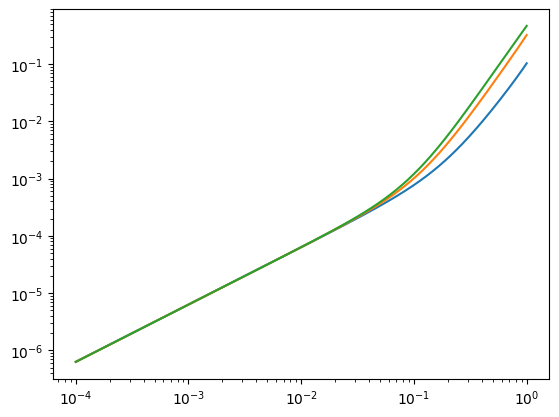

In [68]:
# find the functions chi, chip that correspond to this value of d0
# for all entries in d0_estimate
for d0 in d0_estimate:
    ui=1e-4
    mq1,chi,chip,u=chiral_solve_IR(d0,6.5,T,0,ui,1-ui)
    # find the corresponding value of sigma
    print("quark mass=",mq1)
    # print("sigma=",sig[0]**(1/3))
    plt.loglog(u,chi)
plt.show()


In [7]:
def sigma_temp_scan(mq_input,mq_tolerance,lambda1,mu,tmin,tmax,numtemps):
    T_array=np.linspace(tmin,tmax,numtemps)
    # if tmin<20:
    #     d0_upper=50
    # else:
    #     d0_upper=10
    d0_upper=10
    d0_lower=0
    # create a numpy array of zeros with 3 by numtemps elements to store the sigma values
    sigma_array=np.zeros((3,numtemps))
    for i in range(numtemps):
        try:
            ui=1e-2
            sigma_array[:,i],d0_max,d0_min,_=sigma_of_T(mq_input,mq_tolerance,T_array[i],mu,lambda1,d0_lower,d0_upper,ui)
        except:
            ui=1e-4
            sigma_array[:,i],d0_max,d0_min,_=sigma_of_T(mq_input,mq_tolerance,T_array[i],mu,lambda1,d0_lower,d0_upper,ui)
        # every 10 iterations, print the temperature
        if i%10==0:
            print("Temperature is ", T_array[i])
        d0_upper=d0_max
        d0_lower=max(0,d0_min/2)
    return T_array,sigma_array
    


In [94]:
tmin=68
tmax=70
numtemps=100

lambda1=5
mq_input=9
mq_tolerance=0.01
mu=310

T_array, sigma_array = sigma_temp_scan(mq_input,mq_tolerance,lambda1,mu,tmin,tmax,numtemps)

# T_array=np.linspace(tmin,tmax,numtemps)
# # if tmin<20:
# #     d0_upper=50
# # else:
# #     d0_upper=10
# d0_upper=10
# d0_lower=0


# # create a numpy array of zeros with 3 by numtemps elements to store the sigma values
# sigma_array=np.zeros((3,numtemps))
# for i in range(numtemps):
#     try:
#         ui=1e-2
#         sigma_array[:,i],d0_max,d0_min=sigma_of_T(mq_input,mq_tolerance,T_array[i],mu,lambda1,d0_lower,d0_upper,ui)
#     except:
#         ui=1e-4
#         sigma_array[:,i],d0_max,d0_min=sigma_of_T(mq_input,mq_tolerance,T_array[i],mu,lambda1,d0_lower,d0_upper,ui)
#     # every 10 iterations, print the temperature
#     if i%10==0:
#         print("Temperature is ", T_array[i])
#     d0_upper=d0_max
#     d0_lower=max(0,d0_min/2)
    




/var/folders/p2/x0t9bzsx00jdh9552ryvxndm0000gp/T/ipykernel_8728/1446935064.py:98: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(mq_array), np.array(chi_array), np.array(chip_array)


Temperature is  68.0
Temperature is  68.20202020202021
Temperature is  68.4040404040404
Temperature is  68.60606060606061
Temperature is  68.8080808080808
Temperature is  69.01010101010101
Temperature is  69.21212121212122
Temperature is  69.41414141414141
Temperature is  69.61616161616162
Temperature is  69.81818181818181


In [90]:
import gc
gc.collect()


109264

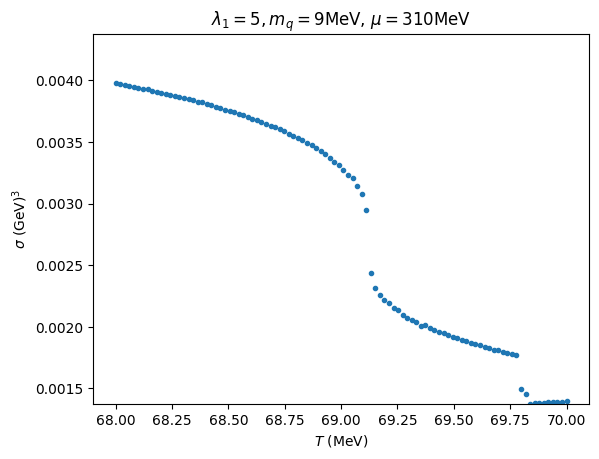

In [95]:
plt.plot(T_array,sigma_array[0,:]/1e9,'.')
plt.plot(T_array,sigma_array[1,:]/1e9,'.')
plt.plot(T_array,sigma_array[2,:]/1e9,'.')
plt.xlabel('$T$ (MeV)')
plt.ylabel('$\sigma$ (GeV)$^3$')
plt.ylim([np.min(sigma_array[0,:]/1e9),1.1*np.max(sigma_array[0,:]/1e9)])
plt.title('$\lambda_1=$'+str(lambda1)+'$, m_q=$'+str(mq_input)+'MeV, $\mu= $'+str(mu)+'MeV')
plt.show()

In [17]:
#find an index of sigma_array[1,:] that is not zero
index=np.where(sigma_array[1,:]!=0)[0][0]
#find the temperature at that index
T=T_array[index]
print(T)

125.3061224489796


# Zooming in to find transition temperature

Start with a large temperature range, and zoom in on the temperature with the largest gradient in $\sigma$. 

Continue until either:
- A First-order phase transition is found ($\sigma$ is multi-valued)
- The temperature range is within a specified value

/var/folders/p2/x0t9bzsx00jdh9552ryvxndm0000gp/T/ipykernel_8728/1446935064.py:98: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(mq_array), np.array(chi_array), np.array(chip_array)


Temperature is  70.0
Temperature is  70.55555555555556
Temperature is  71.11111111111111
Temperature is  71.66666666666667
Temperature is  72.22222222222223
Temperature is  72.77777777777777
Temperature is  73.33333333333333
Temperature is  73.88888888888889
Temperature is  74.44444444444444
Temperature is  75.0
Phase transition between T= 71.83333333333333  and T= 72.0
Temperature is  71.83333333333333
Temperature is  71.85016835016835
Temperature is  71.86700336700336
Temperature is  71.88383838383838
Temperature is  71.9006734006734
Temperature is  71.91750841750842
Temperature is  71.93434343434343
Temperature is  71.95117845117845
Temperature is  71.96801346801347
Temperature is  71.98484848484848
first-order transition at T= 71.97811447811448
Tc= 71.97727272727272 transition_order= 1


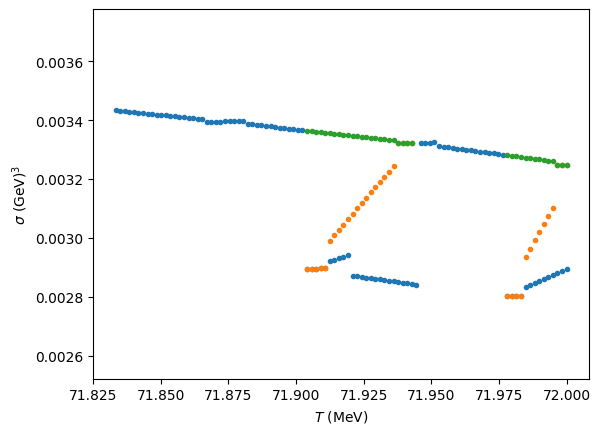

In [78]:
# find the index where the gradient of sigma_array[0,:] is most negative
# this is the index where the approximate transition temperature is

tmin=70
tmax=75.5
numtemps=15

lambda1=5
mq_input=9
mq_tolerance=0.01
mu=280

def sigma_zoom(mq_input,mq_tolerance, lambda1,mu,tmin,tmax,numtemps):

    iterations = 0
    order = 2
    delta_Tc=100

    while(order==2 and iterations<10 and delta_Tc>0.01):
        iterations=iterations+1
        # print("iteration number ",iterations)
        T_array, sigma_array = sigma_temp_scan(mq_input,mq_tolerance,lambda1,mu,tmin,tmax,numtemps)

        transition_index=np.argmin(np.gradient(sigma_array[0,:]))

        #check to see if sigma_array[1,:] has any non-zero values near the transition temperature
        if transition_index+2>len(sigma_array[1,:]):
            max_index=len(sigma_array[1,:])-1
        else:
            max_index=transition_index+2

        min_index=max(0,transition_index-1)
        if max_index == transition_index:
            transition_index=transition_index-1
        # print("indices are ",min_index,max_index)
        if np.max(sigma_array[1,transition_index:max_index])>0:
            # the transition is first-order
            order = 1
            # the transition index is the smallest index in this range where sigma_array[1,:] is nonzero
            nonzero_indices=np.where(sigma_array[1,:]!=0)[0]
            #keep only the elements of nonzero_indices that are greater than or equal to transition_index-1 and less than or equal to max_index
            nonzero_indices=nonzero_indices[(nonzero_indices>=transition_index-1) & (nonzero_indices<=max_index)]
            #the transition occurs at the smallest of these temperatures
            transition_index=nonzero_indices[0]
            print('first-order transition at T=',T_array[transition_index])
        else:
            # no evidence of a first-order transition
            # the transition is in the range of T_array[transition_index-1] to T_array[transition_index+1]
            print('Phase transition between T=',T_array[min_index],' and T=',T_array[min(max_index,len(T_array)-1)])
            tmin=T_array[max(0,transition_index-1)]
            tmax=T_array[min(max_index,len(T_array)-1)]
        Tc= 0.5*(T_array[transition_index]+T_array[transition_index-1])
        delta_Tc=(T_array[transition_index]-T_array[transition_index-1])/2
    return(T_array,sigma_array,Tc,delta_Tc,order)

T_array,sigma_array,Tc,delta_Tc,transition_order=sigma_zoom(mq_input,mq_tolerance, lambda1,mu,tmin,tmax,numtemps)

print("Tc=", Tc, "transition_order=",transition_order)

plt.plot(T_array,sigma_array[0,:]/1e9,'.')
plt.plot(T_array,sigma_array[1,:]/1e9,'.')
plt.plot(T_array,sigma_array[2,:]/1e9,'.')
plt.ylim(0.9*min(sigma_array[0,:]/1e9),1.1*max(sigma_array[0,:]/1e9))
plt.xlabel('$T$ (MeV)')
plt.ylabel('$\sigma$ (GeV)$^3$')
plt.show()



In [23]:
(sigma_array[2,index-1:index+2])

array([      0.        ,       0.        , 2737810.85032734])

In [30]:

mu_0=300 
delta_mu=16
tmin=15
tmax=100
lambda1=5
numtemps=15
def mu_scan(mq_input,mq_tolerance, lambda1,mu,tmin,tmax,numtemps,mu_0,delta_mu):
    transition_order = 2
    mu=mu_0
    mu_list=[]
    Tc_list=[]
    delta_Tc_list=[]
    order_list=[]
    while transition_order == 2:
        T_array,sigma_array,Tc,delta_Tc,transition_order=sigma_zoom(mq_input,mq_tolerance, lambda1,mu,tmin,tmax,numtemps)
        print('mu=',mu)
        print('transition_order=',transition_order)
        print('Tc=',Tc)
        mu_list.append(mu)
        Tc_list.append(Tc)
        delta_Tc_list.append(delta_Tc)
        order_list.append(transition_order)
        mu=mu+delta_mu
        tmax=Tc+2*delta_Tc
        if Tc-tmin<10:
            tmin=max(0,Tc-5)
    return mu_list,Tc_list,delta_Tc_list,order_list


In [48]:

def critical_point_finder(mq_input,mq_tolerance, lambda1,tmin,tmax,numtemps,mu_0,delta_mu,mu_precision):
   mu_list=[]
   Tc_list=[]
   delta_Tc_list=[]
   order_list=[]
   while delta_mu >mu_precision:
      mu_new,Tc_new,delta_Tc_new,order_new= mu_scan(mq_input,mq_tolerance, lambda1,mu,tmin,tmax,numtemps,mu_0,delta_mu)

      # join mu_list and mu_new
      mu_list=mu_list+mu_new
      Tc_list=Tc_list+Tc_new
      delta_Tc_list=delta_Tc_list+delta_Tc_new
      order_list=order_list+order_new

      # #sort mu_list, Tc_list, delta_Tc_list, order_list by mu_list
      indices=np.argsort(mu_list)
      mu_list=np.array(mu_list)[indices]
      Tc_list=np.array(Tc_list)[indices]
      delta_Tc_list=np.array(delta_Tc_list)[indices]
      order_list=np.array(order_list)[indices]

      #convert these arrays back to lists
      mu_list=mu_list.tolist()
      Tc_list=Tc_list.tolist()
      delta_Tc_list=delta_Tc_list.tolist()
      order_list=order_list.tolist()
      
      
      
      #find the largest value of mu with order = 2
      indices=np.where(np.array(order_list)==2)[0]
      mu_lower=mu_list[indices[-1]]
      tmax=Tc_list[indices[-1]]+5 #to give a buffer

      #find the smallest value of mu with order = 1
      indices=np.where(np.array(order_list)==1)[0]
      mu_upper=mu_list[indices[0]]

      print('------- Critical point found -------')
      print('between mu=',mu_lower,' and mu=',mu_upper)
      print('Tc=',Tc_list[indices[-1]])
      print('delta_mu = ',delta_mu)
      print('------------------------------------')

      #set mu_0 to the midpoint of mu_lower and mu_upper
      mu_0=(mu_lower+mu_upper)/2
      delta_mu=(mu_upper-mu_0)/2

   return mu_list,Tc_list,delta_Tc_list,order_list



For a particular value of $\lambda_1$, find the critical point, and save all the $\mu, T_c$ combinations to a csv file.

In [97]:
lambda1=4.6
mq_input=9
mq_tolerance=0.1
tmin=15
tmax=110
numtemps=15
mu_0=310
delta_mu=16
mu_precision=0.5


mu_list,Tc_list,delta_Tc_list,order_list=critical_point_finder(mq_input,mq_tolerance, lambda1,tmin,tmax,numtemps,mu_0,delta_mu,mu_precision)

#if mu_list has any duplicate values, remove them and the corresponding values of Tc_list, delta_Tc_list, order_list
mu_list=np.array(mu_list)
Tc_list=np.array(Tc_list)
delta_Tc_list=np.array(delta_Tc_list)
order_list=np.array(order_list)
indices=np.unique(mu_list,return_index=True)[1]
mu_list=mu_list[indices]
Tc_list=Tc_list[indices]
delta_Tc_list=delta_Tc_list[indices]
order_list=order_list[indices]

#save these arrays to a csv file in the data folder, titled by the value of mq_input and lambda1
data=np.array([mu_list,Tc_list,delta_Tc_list,order_list])
data=data.T
#give the columns names
df=pd.DataFrame(data,columns=['mu','Tc','delta_Tc','order'])
#save the dataframe to a csv file
df.to_csv('data/critical_point_mq='+str(mq_input)+'_lambda1='+str(lambda1)+'.csv',index=False)


/var/folders/p2/x0t9bzsx00jdh9552ryvxndm0000gp/T/ipykernel_8728/1446935064.py:98: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(mq_array), np.array(chi_array), np.array(chip_array)


Temperature is  15.0
Temperature is  82.85714285714286
Phase transition between T= 48.92857142857143  and T= 69.28571428571428
Temperature is  48.92857142857143
Temperature is  63.469387755102034
Phase transition between T= 57.65306122448979  and T= 62.015306122448976
Temperature is  57.65306122448979
Temperature is  60.76895043731778
Phase transition between T= 59.21100583090379  and T= 60.14577259475218
Temperature is  59.21100583090379
Temperature is  59.87869637650978
Phase transition between T= 59.67838921282798  and T= 59.87869637650978
Temperature is  59.67838921282798
Temperature is  59.82146575831498
Phase transition between T= 59.73561983102278  and T= 59.77854279466888
mu= 310
transition_order= 2
Tc= 59.74277365829713
Temperature is  15.0
Temperature is  46.96934379488988
Phase transition between T= 56.56014693335684  and T= 59.757081312845834
Temperature is  53.363212553867854
Temperature is  57.93026166742355
Phase transition between T= 57.01685184471241  and T= 58.3869665

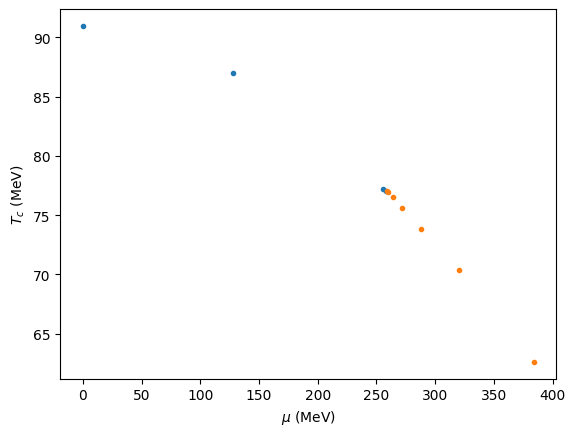

In [64]:
#find the mu values that have order = 2
indices=np.where(np.array(order_list)==2)[0]
mu_2o=np.array(mu_list)[indices]
Tc_2o=np.array(Tc_list)[indices]

#find the mu values that have order = 1
indices=np.where(np.array(order_list)==1)[0]
mu_1o=np.array(mu_list)[indices]
Tc_1o=np.array(Tc_list)[indices]

#plot the mu values that have order = 2
plt.plot(mu_2o,Tc_2o,'.')
plt.plot(mu_1o,Tc_1o,'.')
plt.xlabel('$\mu$ (MeV)')
plt.ylabel('$T_c$ (MeV)')
plt.show()


In [ ]:
import os
# create an array of lambda_1 values from 4.9 to 7.5 in steps of 0.1
lambda1_max=4.8
lambda1_min=4.7
lambda1_step=0.05
#make the array from large to small, because the critical mu value is strictly increasing in that direction
lambda1_array=np.arange(lambda1_max,lambda1_min-lambda1_step,-lambda1_step)

mu_0=300
delta_mu=128
mu_precision=0.5

mq_input=9
mq_tolerance=0.1
tmin=15
tmax=150

# create empty lists to store the critical mu and Tc values
critical_mu_list=[]
critical_Tc_list=[]
lambda1_list=[]


#read in the data from the csv file
try:
    df=pd.read_csv('data/critical_points_mq='+str(mq_input)+'.csv')
    lambda1_list=df['lambda1'].values
    critical_mu_list=df['mu'].values
    critical_Tc_list=df['Tc'].values
    #convert from arrays to lists
    lambda1_list=lambda1_list.tolist()
    critical_mu_list=critical_mu_list.tolist()
    critical_Tc_list=critical_Tc_list.tolist()
except: 
    pass




for lambda1 in lambda1_array:
    print('------- lambda1=',lambda1,' -------')
    # first, check to see if there is already a csv file with the critical point data for this value of lambda1
    filename='data/critical_point_mq='+str(mq_input)+'_lambda1='+str(lambda1)+'.csv'
    if os.path.isfile(filename):
        # if there is, read the data from the csv file
        df=pd.read_csv(filename)
        mu_list=df['mu'].values
        Tc_list=df['Tc'].values
        delta_Tc_list=df['delta_Tc'].values
        order_list=df['order'].values
        #find the mu values that have order = 2
        indices=np.where(np.array(order_list)==2)[0]
        mu_2o=np.array(mu_list)[indices]
        Tc_2o=np.array(Tc_list)[indices]

        #find the mu values that have order = 1
        indices=np.where(np.array(order_list)==1)[0]
        mu_1o=np.array(mu_list)[indices]
        Tc_1o=np.array(Tc_list)[indices]
        mu_upper=mu_1o[0]
        mu_lower=mu_2o[-1]
        T_upper=Tc_1o[0]
        T_lower=Tc_2o[-1]
        critical_mu_list.append((mu_upper+mu_lower)/2)
        critical_Tc_list.append((T_upper+T_lower)/2)
        lambda1_list.append(lambda1)
    else:
        # if there is not, find the critical point data and save it to a csv file

        #check to see if the transition is first-order at mu=0
        # if it is, then there is no critical point, so do not call critical_point_finder
        _,_,Tc,delta_Tc,transition_at_mu_0=sigma_zoom(mq_input,mq_tolerance, lambda1,0,tmin,tmax,numtemps)
        if transition_at_mu_0 == 1:
            critical_mu_list.append(0)
            critical_Tc_list.append(Tc)
            lambda1_list.append(lambda1)
            print('------- NO critical point for the following values -------')
            print('lambda1=',lambda1, "mq = ", mq_input)
        else:
            mu_list,Tc_list,delta_Tc_list,order_list=critical_point_finder(mq_input,mq_tolerance, lambda1,tmin,tmax,numtemps,mu_0,delta_mu,mu_precision)
            data=np.array([mu_list,Tc_list,delta_Tc_list,order_list])
            data=data.T
            #give the columns names
            df=pd.DataFrame(data,columns=['mu','Tc','delta_Tc','order'])
            #save the dataframe to a csv file
            df.to_csv(filename,index=False)
            #find the mu values that have order = 2
            indices=np.where(np.array(order_list)==2)[0]
            mu_2o=np.array(mu_list)[indices]
            Tc_2o=np.array(Tc_list)[indices]

            #find the mu values that have order = 1
            indices=np.where(np.array(order_list)==1)[0]
            mu_1o=np.array(mu_list)[indices]
            Tc_1o=np.array(Tc_list)[indices]
            mu_upper=mu_1o[0]
            mu_lower=mu_2o[-1]
            T_upper=Tc_1o[0]
            T_lower=Tc_2o[-1]
            critical_mu_list.append((mu_upper+mu_lower)/2)
            critical_Tc_list.append((T_upper+T_lower)/2)
            print('------- Critical point found -------')
            print('lambda1=',lambda1, "mq = ", mq_input)
            print('mu=',(mu_upper+mu_lower)/2)
            print('Tc=',(T_upper+T_lower)/2)
    mu_0=mu_lower

#save the critical mu and Tc values to a csv file
# convert the lists to numpy arrays
lambda1_list=np.array(lambda1_list)
critical_mu_list=np.array(critical_mu_list)
critical_Tc_list=np.array(critical_Tc_list)

data=np.array([lambda1_list,critical_mu_list,critical_Tc_list])
data=data.T
#give the columns names
df=pd.DataFrame(data,columns=['lambda1','mu','Tc'])
#save the dataframe to a csv file
df.to_csv('data/critical_points_mq='+str(mq_input)+'.csv',index=False)




------- lambda1= 5.5  -------
------- lambda1= 5.505  -------


/var/folders/p2/x0t9bzsx00jdh9552ryvxndm0000gp/T/ipykernel_8728/1446935064.py:98: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(mq_array), np.array(chi_array), np.array(chip_array)


Temperature is  15.0
Temperature is  111.42857142857142
Phase transition between T= 92.14285714285714  and T= 121.07142857142857
Temperature is  92.14285714285714
Temperature is  112.80612244897958
Phase transition between T= 100.40816326530611  and T= 106.60714285714286
Temperature is  100.40816326530611
Temperature is  104.83600583090379
Phase transition between T= 102.62208454810495  and T= 103.95043731778425
Temperature is  102.62208454810495
Temperature is  103.57090795501874
Phase transition between T= 103.09649625156185  and T= 103.38114327363598
Temperature is  103.09649625156185
Temperature is  103.29981555304337
Phase transition between T= 103.23881976259892  and T= 103.29981555304337
Temperature is  103.23881976259892
Temperature is  103.28238818434495
Phase transition between T= 103.25189028912273  and T= 103.26496081564655
Temperature is  15.0
Temperature is  111.42857142857142
Phase transition between T= 92.14285714285714  and T= 121.07142857142857
Temperature is  92.1428

/var/folders/p2/x0t9bzsx00jdh9552ryvxndm0000gp/T/ipykernel_8728/1446935064.py:98: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(mq_array), np.array(chi_array), np.array(chip_array)


Temperature is  15.0
Temperature is  111.42857142857142
Phase transition between T= 92.14285714285714  and T= 121.07142857142857
Temperature is  92.14285714285714
Temperature is  112.80612244897958
Phase transition between T= 100.40816326530611  and T= 106.60714285714286
Temperature is  100.40816326530611
Temperature is  104.83600583090379
Phase transition between T= 103.06486880466473  and T= 104.39322157434403
Temperature is  103.06486880466473
Temperature is  104.01369221157852
Phase transition between T= 103.34951582673887  and T= 103.63416284881299
Temperature is  103.34951582673887
Temperature is  103.55283512822038
Phase transition between T= 103.36984775688701  and T= 103.43084354733148
Temperature is  103.36984775688701
Temperature is  103.41341617863306
Phase transition between T= 103.37856144123622  and T= 103.39163196776003
Temperature is  15.0
Temperature is  111.42857142857142
Phase transition between T= 92.14285714285714  and T= 121.07142857142857
Temperature is  92.1428

/var/folders/p2/x0t9bzsx00jdh9552ryvxndm0000gp/T/ipykernel_8728/1446935064.py:98: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(mq_array), np.array(chi_array), np.array(chip_array)


Temperature is  15.0
Temperature is  111.42857142857142
Phase transition between T= 92.14285714285714  and T= 121.07142857142857
Temperature is  92.14285714285714
Temperature is  112.80612244897958
Phase transition between T= 100.40816326530611  and T= 106.60714285714286
Temperature is  100.40816326530611
Temperature is  104.83600583090379
Phase transition between T= 103.06486880466473  and T= 104.39322157434403
Temperature is  103.06486880466473
Temperature is  104.01369221157852
Phase transition between T= 103.34951582673887  and T= 103.63416284881299
Temperature is  103.34951582673887
Temperature is  103.55283512822038
Phase transition between T= 103.49183933777593  and T= 103.55283512822038
Temperature is  103.49183933777593
Temperature is  103.53540775952196
Phase transition between T= 103.50490986429973  and T= 103.51798039082355
Temperature is  15.0
Temperature is  111.42857142857142
Phase transition between T= 92.14285714285714  and T= 121.07142857142857
Temperature is  92.1428

/var/folders/p2/x0t9bzsx00jdh9552ryvxndm0000gp/T/ipykernel_8728/1446935064.py:98: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(mq_array), np.array(chi_array), np.array(chip_array)


Temperature is  15.0
Temperature is  111.42857142857142
Phase transition between T= 92.14285714285714  and T= 121.07142857142857
Temperature is  92.14285714285714
Temperature is  112.80612244897958
Phase transition between T= 100.40816326530611  and T= 106.60714285714286
Temperature is  100.40816326530611
Temperature is  104.83600583090379
Phase transition between T= 103.06486880466473  and T= 104.39322157434403
Temperature is  103.06486880466473
Temperature is  104.01369221157852
Phase transition between T= 103.53928050812162  and T= 103.82392753019576
Temperature is  103.53928050812162
Temperature is  103.74259980960315
Phase transition between T= 103.62060822871423  and T= 103.6816040191587
Temperature is  103.62060822871423
Temperature is  103.66417665046028
Phase transition between T= 103.63367875523805  and T= 103.64674928176186
Temperature is  15.0
Temperature is  111.42857142857142
Phase transition between T= 92.14285714285714  and T= 121.07142857142857
Temperature is  92.14285

/var/folders/p2/x0t9bzsx00jdh9552ryvxndm0000gp/T/ipykernel_8728/1446935064.py:98: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(mq_array), np.array(chi_array), np.array(chip_array)


Temperature is  15.0
Temperature is  111.42857142857142
Phase transition between T= 92.14285714285714  and T= 121.07142857142857
Temperature is  92.14285714285714
Temperature is  112.80612244897958
Phase transition between T= 100.40816326530611  and T= 106.60714285714286
Temperature is  100.40816326530611
Temperature is  104.83600583090379
Phase transition between T= 103.06486880466473  and T= 104.39322157434403
Temperature is  103.06486880466473
Temperature is  104.01369221157852
Phase transition between T= 103.63416284881299  and T= 103.91880987088713
Temperature is  103.63416284881299
Temperature is  103.83748215029452
Phase transition between T= 103.75615442970191  and T= 103.81715022014637
Temperature is  103.75615442970191
Temperature is  103.79972285144795
Phase transition between T= 103.76051127187651  and T= 103.77358179840033
Temperature is  15.0
Temperature is  111.42857142857142
Phase transition between T= 92.14285714285714  and T= 121.07142857142857
Temperature is  92.1428

/var/folders/p2/x0t9bzsx00jdh9552ryvxndm0000gp/T/ipykernel_8728/1446935064.py:98: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(mq_array), np.array(chi_array), np.array(chip_array)


Temperature is  15.0
Temperature is  111.42857142857142
Phase transition between T= 92.14285714285714  and T= 121.07142857142857
Temperature is  92.14285714285714
Temperature is  112.80612244897958
Phase transition between T= 100.40816326530611  and T= 106.60714285714286
Temperature is  100.40816326530611
Temperature is  104.83600583090379
Phase transition between T= 103.50765306122449  and T= 104.83600583090379
Temperature is  103.50765306122449
Temperature is  104.45647646813828
first-order transition at T= 103.88718242399
------- NO critical point for the following values -------
lambda1= 5.529999999999999 mq =  9


/var/folders/p2/x0t9bzsx00jdh9552ryvxndm0000gp/T/ipykernel_8728/1265367634.py:104: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data=np.array([lambda1_list,critical_mu_list,critical_Tc_list])


ValueError: Shape of passed values is (3, 1), indices imply (3, 3)

In [71]:
len(lambda1_list)

20

In [73]:
data

array([list([5.4, 5.41, 5.42, 5.43, 5.44, 5.449999999999999, 5.459999999999999, 5.469999999999999, 5.479999999999999, 5.489999999999998, 5.499999999999998, 5.509999999999998, 5.519999999999998, 5.529999999999998, 5.539999999999997, 5.549999999999997, 5.559999999999997, 5.569999999999997, 5.5799999999999965, 5.589999999999996]),
       list([165.0, 157.0, 257.0, 144.5, 137.0, 129.0, 257.0, 114.5, 96.0, 80.0, 66.0, 65.0, 149.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 66.0, 69.0, 65.0, 131.5, 149.0, 33.0, 0]),
       list([93.53343683424052, 94.42215045797764, 85.02952318693829, 95.86757514073436, 96.66433310647858, 97.4600605640852, 86.4010987146206, 98.87710968711744, 100.1195941455224, 101.12133839065226, 101.91469434880224, 102.219335500106, 97.85439322028844, 103.83974125364432, 104.13455424079253, 104.17182944606414, 104.61950842654844, 104.86575069167608, 104.90980320699708, 105.30514629321117, 101.91469434880224, 101.94736485688952, 102.21933550010601, 98.91121468388515, 97.85439322028